# Fecha tentativa de entrega: 1 de julio

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dummy-data/reduced_train_data_2.csv
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amex-data/reduced_data.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import io
from math import pi
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, make_scorer,classification_report
from sklearn.neighbors import LocalOutlierFactor

# Revisar codigo de generacion de dataset reducido

```py
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils.random import sample_without_replacement
from pathlib import Path

filename = '/Users/ignaciogarcia/Downloads/tp3_kaggle/train_data.csv'

def row_count():
    with open(filename) as f:
        return sum(1 for line in f)

state = (31416 * 9) % 1000 #Grupo 9
count = row_count()
keep_rows = sample_without_replacement(n_population=count, n_samples=int(count * (0.05)), random_state=state)
keep_rows = np.insert(keep_rows, 0,0, axis=0)
data = pd.read_csv(filename, skiprows=lambda x: x not in keep_rows)
filepath = Path('/Users/ignaciogarcia/Downloads/tp3_kaggle/reduced_data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath)
```

In [3]:
data = pd.read_csv('../input/amex-data/reduced_data.csv')

data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2017-10-23,0.606677,0.033809,0.025544,0.815019,0.000523,0.172446,0.003708,0.000053,...,NaN,NaN,NaN,0.008022,0.004774,0.004846,NaN,0.000654,0.001793,0.006356
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-11-10,0.407172,0.001548,0.106145,0.048557,0.001353,0.330037,0.009187,0.223204,...,NaN,NaN,NaN,0.000510,0.001478,0.009909,NaN,0.004614,0.007917,0.006711
2,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,2017-10-15,1.005125,0.215301,0.099128,0.082039,0.005363,0.092882,0.001929,0.158300,...,NaN,NaN,NaN,0.006687,0.007377,0.008373,NaN,0.009990,0.002785,0.009664
3,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-03-15,0.400025,0.000278,0.954861,0.023890,0.003140,NaN,0.008421,1.175081,...,NaN,NaN,NaN,1.002518,0.001170,0.870115,0.141214,1.003923,0.008945,0.736632
4,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-07-01,0.311111,0.592908,0.096867,0.040793,0.002294,0.460324,0.009938,0.223131,...,NaN,NaN,NaN,0.001164,0.001779,0.004852,NaN,0.006252,0.008367,0.005460


In [5]:
d_columns = data.filter(regex='D_')

d_columns

,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0.033809,0.003708,NaN,0.064441,0.008099,0.076411,0.443989,0.409156,0.048084,NaN,...,NaN,NaN,NaN,0.008022,0.004774,0.004846,NaN,0.000654,0.001793,0.006356
1,0.001548,0.009187,0.139045,0.068893,0.009326,0.025337,NaN,0.014981,0.208866,NaN,...,NaN,NaN,NaN,0.000510,0.001478,0.009909,NaN,0.004614,0.007917,0.006711
2,0.215301,0.001929,NaN,0.009967,0.002224,0.339116,0.423821,0.516960,0.053792,NaN,...,NaN,NaN,NaN,0.006687,0.007377,0.008373,NaN,0.009990,0.002785,0.009664
3,0.000278,0.008421,NaN,0.066728,0.378491,0.074820,0.599260,0.113653,0.636184,NaN,...,NaN,NaN,NaN,1.002518,0.001170,0.870115,0.141214,1.003923,0.008945,0.736632
4,0.592908,0.009938,0.295201,0.053988,0.126802,0.021206,0.426132,0.624164,0.617264,NaN,...,NaN,NaN,NaN,0.001164,0.001779,0.004852,NaN,0.006252,0.008367,0.005460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276567,0.002464,0.000088,NaN,0.103616,0.006331,0.074404,0.435649,0.217762,0.075654,NaN,...,NaN,NaN,NaN,0.009720,0.009944,0.001952,NaN,0.007779,0.005021,0.005594
276568,0.036332,0.007207,NaN,NaN,0.126725,0.603829,0.463519,0.759647,0.113236,0.014559,...,NaN,NaN,NaN,0.005813,0.002701,0.004963,NaN,0.008592,0.009413,0.007067
276569,0.236684,0.000588,NaN,0.051606,0.008688,0.132907,0.558068,0.324458,0.138048,NaN,...,NaN,NaN,NaN,0.006160,0.009230,0.009029,NaN,0.009720,0.007795,0.006619
276570,0.005489,0.001709,NaN,NaN,0.007109,0.126404,0.543028,0.568976,0.382296,NaN,...,NaN,NaN,NaN,1.006073,0.006703,0.932688,0.402209,1.004450,0.007339,0.186192


In [6]:
for col in data.filter(regex='P_').columns:
    print(col,": ",data[col].isna().sum())

P_2 :  2290
P_3 :  15099
P_4 :  0


In [7]:
p_index = data.filter(regex='P_')

p_index.corr().style.background_gradient(cmap='coolwarm')

,P_2,P_3,P_4
P_2,1.000000,0.399280,-0.279263
P_3,0.399280,1.000000,-0.107236
P_4,-0.279263,-0.107236,1.000000


<AxesSubplot:xlabel='P_3'>

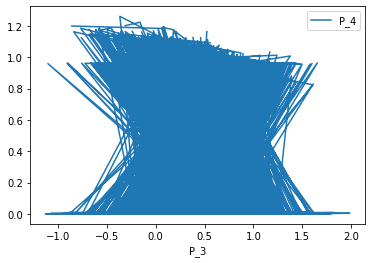

In [8]:
p_index.plot(x='P_3', y='P_4')

In [9]:
r_index = data.filter(regex='R_')

r_index.corr().style.background_gradient(cmap='coolwarm')

,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28
R_1,1.000000,0.640525,0.166690,0.631430,0.489872,0.308536,0.200213,0.437520,0.048685,0.576559,0.054533,-0.163660,0.298069,0.108189,0.478536,0.098967,0.223180,0.008905,0.213670,0.282551,0.357343,0.100131,0.026491,0.412238,0.133990,0.118880,-0.162377,0.042675
R_2,0.640525,1.000000,0.070530,0.780607,0.552100,0.393001,0.249867,0.516819,0.109391,0.189189,-0.009260,-0.137676,0.317588,0.144371,0.282498,0.025571,0.235688,0.010787,0.042774,0.380146,0.043391,0.038133,0.000672,0.558121,0.079228,0.090802,-0.115887,-0.002292
R_3,0.166690,0.070530,1.000000,0.053490,0.047441,0.027695,0.017768,0.050716,-0.046635,0.114546,0.261315,-0.057725,0.027608,0.002763,0.072742,0.495435,0.010587,-0.002356,0.002597,0.026762,0.083076,0.013509,0.013710,0.040259,0.023909,0.134030,-0.249443,0.028108
R_4,0.631430,0.780607,0.053490,1.000000,0.676906,0.417972,0.319534,0.624472,0.029323,0.197943,-0.009961,-0.112420,0.394972,0.059422,0.281475,0.015658,0.296866,0.001768,0.039032,0.181651,0.041136,0.023114,-0.000255,0.235440,0.066122,0.075012,-0.094834,-0.001628
R_5,0.489872,0.552100,0.047441,0.676906,1.000000,0.348016,0.240176,0.804793,0.010043,0.189789,-0.010549,-0.088214,0.675238,0.048802,0.281642,0.008727,0.513191,0.002710,0.035782,0.187017,0.033989,0.008038,0.001537,0.212782,0.056136,0.072419,-0.083194,0.001697
R_6,0.308536,0.393001,0.027695,0.417972,0.348016,1.000000,0.602678,0.300163,0.023935,0.088241,-0.005637,-0.044182,0.212327,0.325651,0.125350,0.008036,0.173811,0.002462,0.024605,0.217055,0.025118,0.014287,-0.001182,0.246345,0.021215,0.036540,-0.042801,-0.001045
R_7,0.200213,0.249867,0.017768,0.319534,0.240176,0.602678,1.000000,0.222577,0.007654,0.063687,-0.004390,-0.044331,0.150281,0.018207,0.098531,0.005784,0.093715,0.000234,0.042168,0.029379,0.012782,0.006297,0.000529,0.042115,0.030625,0.015944,-0.021504,-0.001149
R_8,0.437520,0.516819,0.050716,0.624472,0.804793,0.300163,0.222577,1.000000,0.017715,0.198967,-0.006610,-0.079150,0.341923,0.027528,0.239999,0.010605,0.115289,-0.000052,0.037223,0.081060,0.034345,0.012667,0.000086,0.119779,0.058075,0.052412,-0.069712,0.001793
R_9,0.048685,0.109391,-0.046635,0.029323,0.010043,0.023935,0.007654,0.017715,1.000000,-0.007473,-0.032772,-0.042878,0.006515,0.027522,-0.016152,-0.020862,-0.006237,-0.008855,-0.019141,0.106376,-0.030304,0.014136,-0.007336,0.113446,0.022756,0.022280,-0.008738,-0.014323
R_10,0.576559,0.189189,0.114546,0.197943,0.189789,0.088241,0.063687,0.198967,-0.007473,1.000000,0.031098,-0.081903,0.104561,0.021600,0.101708,0.047786,0.057074,0.001852,0.078260,0.058486,0.063491,0.038899,0.001878,0.074357,0.045079,0.077929,-0.122680,0.000886


In [10]:
b_index = data.filter(regex='B_')

b_index.corr().style.background_gradient(cmap='coolwarm')

,B_1,B_2,B_3,B_4,B_5,B_6,B_7,B_8,B_9,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_40,B_41,B_42
B_1,1.000000,-0.630759,0.730315,0.494929,-0.066263,-0.060472,0.633359,0.131078,0.544330,-0.020643,0.995761,-0.066177,-0.029904,0.239070,0.018033,0.584505,0.403676,-0.571160,0.716484,0.625461,0.107439,0.619966,0.635529,0.040569,0.525092,-0.002804,-0.000307,0.342484,-0.005933,0.605655,-0.029753,0.143269,-0.566172,0.077809,0.993286,0.581486,-0.338220,0.067319,0.034628,-0.110345
B_2,-0.630759,1.000000,-0.714550,-0.508384,0.119101,0.082746,-0.590391,-0.203894,-0.611095,0.029116,-0.603475,0.094758,0.066860,-0.174167,-0.025959,-0.774643,-0.682482,0.848585,-0.628340,-0.788265,-0.079497,-0.641791,-0.583820,-0.050243,-0.355816,-0.021878,-0.002738,-0.333216,-0.058723,-0.597149,0.031956,-0.217314,0.912341,0.003446,-0.634003,-0.671211,-0.036093,-0.084303,-0.052804,0.169063
B_3,0.730315,-0.714550,1.000000,0.546715,-0.063774,-0.068374,0.629266,0.095747,0.534680,-0.022604,0.717911,-0.058620,-0.042726,0.220091,0.059480,0.724147,0.469647,-0.652458,0.789582,0.764512,0.054610,0.750290,0.636459,0.053020,0.393341,0.004365,-0.000081,0.386533,0.015595,0.691345,-0.031747,0.252725,-0.638521,0.001571,0.733435,0.669539,0.016302,0.087314,0.043683,-0.130439
B_4,0.494929,-0.508384,0.546715,1.000000,-0.006301,-0.079479,0.689946,0.084563,0.416742,-0.027009,0.493667,0.046783,0.047213,0.313785,0.176181,0.529571,0.329230,-0.656181,0.469911,0.547391,0.034112,0.495709,0.727029,0.054252,0.367785,0.050830,0.007009,0.732807,0.078043,0.389045,-0.025512,0.133762,-0.482138,0.074195,0.491396,0.456835,-0.193527,0.119202,0.039806,-0.122411
B_5,-0.066263,0.119101,-0.063774,-0.006301,1.000000,0.010731,-0.109153,-0.092708,-0.061511,0.008631,-0.058554,0.534648,0.457121,0.421470,0.440377,-0.056141,-0.070874,0.076142,-0.080164,-0.063044,-0.013642,-0.054308,-0.101162,-0.024555,0.063235,0.049998,0.000428,0.236779,0.012062,-0.074065,0.011406,-0.031276,0.057091,0.001881,-0.066119,-0.041571,0.028096,-0.014821,-0.017181,0.140475
B_6,-0.060472,0.082746,-0.068374,-0.079479,0.010731,1.000000,-0.087080,-0.018965,-0.059228,0.037876,-0.057503,0.028283,0.053081,-0.017562,-0.003171,-0.088137,-0.171395,0.114194,-0.063908,-0.076755,-0.006441,-0.058774,-0.084854,-0.006858,-0.034631,-0.001216,-0.001124,-0.057252,-0.013794,-0.052483,0.004030,-0.020185,0.083727,-0.006653,-0.060141,-0.074263,0.180445,-0.015909,-0.004985,0.076833
B_7,0.633359,-0.590391,0.629266,0.689946,-0.109153,-0.087080,1.000000,0.124624,0.473009,-0.030429,0.614542,-0.100052,-0.075001,0.106112,-0.013303,0.557990,0.389318,-0.665215,0.622167,0.589397,0.063124,0.514456,0.995099,0.035252,0.277890,-0.006952,-0.001256,0.443481,-0.002936,0.499371,-0.026442,0.207238,-0.515712,0.028973,0.632145,0.528553,-0.243678,0.166485,0.030348,-0.149444
B_8,0.131078,-0.203894,0.095747,0.084563,-0.092708,-0.018965,0.124624,1.000000,0.280426,-0.003863,0.109843,-0.079439,-0.056477,-0.081039,-0.101885,0.105346,0.085442,-0.184769,0.147208,0.060004,0.056970,0.074347,0.104532,0.033653,0.023592,-0.011067,-0.000633,-0.069365,0.020044,0.147424,-0.023398,0.027458,-0.186055,0.017571,0.129371,0.154878,-0.018000,0.020117,0.044541,-0.092197
B_9,0.544330,-0.611095,0.534680,0.416742,-0.061511,-0.059228,0.473009,0.280426,1.000000,-0.018652,0.518967,-0.034819,-0.015292,0.162283,-0.042976,0.547006,0.391147,-0.570383,0.507183,0.538898,0.079521,0.477875,0.466351,0.089362,0.472700,-0.002727,-0.001682,0.265853,0.035101,0.473884,-0.047883,0.137543,-0.586679,0.065487,0.541105,0.532606,-0.317696,0.069383,0.082007,-0.092022
B_10,-0.020643,0.029116,-0.022604,-0.027009,0.008631,0.037876,-0.030429,-0.003863,-0.018652,1.000000,-0.019627,0.019140,0.036958,-0.004666,-0.000328,-0.028334,-0.038717,0.041817,-0.020550,-0.025749,-0.002475,-0.019921,-0.029364,0.002372,-0.010324,-0.000784,0.001798,-0.019414,-0.004228,-0.017797,-0.001303,-0.006633,0.030881,-0.001521,-0.020666,-0.020766,0.002587,-0.005559,

In [11]:
p_index = data.filter(regex='P_')

p_index.corr().style.background_gradient(cmap='coolwarm')

,P_2,P_3,P_4
P_2,1.000000,0.399280,-0.279263
P_3,0.399280,1.000000,-0.107236
P_4,-0.279263,-0.107236,1.000000


In [12]:
d_index = data.filter(regex='D_')

d_index.corr().style.background_gradient(cmap='coolwarm')

/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


Candidatas a ser dropeadas

In [13]:
d_index[['D_87']]

,D_87
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
276567,NaN
276568,NaN
276569,NaN
276570,NaN


In [14]:
d_index[['D_110']]

,D_110
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
276567,NaN
276568,NaN
276569,NaN
276570,NaN


In [15]:
d_index[['D_111']]

,D_111
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
276567,NaN
276568,NaN
276569,NaN
276570,NaN


In [16]:
s_index = data.filter(regex='S_')

s_index.corr().style.background_gradient(cmap='coolwarm')
#plt.show()

,S_3,S_5,S_6,S_7,S_8,S_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27
S_3,1.000000,0.052451,0.035901,0.905611,-0.398868,0.050409,-0.157388,0.009240,-0.187422,0.475978,0.154357,0.079817,0.014962,0.024512,0.211252,0.015394,0.151778,0.014111,-0.088961,-0.059916,0.100756
S_5,0.052451,1.000000,-0.116459,0.072286,0.116733,0.061027,0.049791,0.062514,0.202634,-0.042966,0.038903,0.008506,0.163271,0.004757,0.032289,0.057857,0.043208,0.065993,-0.006043,0.087161,0.080706
S_6,0.035901,-0.116459,1.000000,0.005109,-0.455488,0.027439,-0.217276,-0.082872,-0.372774,0.295300,-0.023902,-0.063418,-0.072946,-0.001717,-0.037125,-0.271128,-0.036960,-0.317912,0.102816,-0.066010,0.015622
S_7,0.905611,0.072286,0.005109,1.000000,-0.344138,0.038342,-0.129572,0.034382,-0.117351,0.417149,0.140825,0.078533,0.014323,0.023456,0.198384,0.028740,0.161461,0.028887,-0.082731,-0.045604,0.128567
S_8,-0.398868,0.116733,-0.455488,-0.344138,1.000000,-0.046041,0.358117,0.162344,0.695561,-0.789062,-0.003523,0.046146,0.088351,-0.000419,-0.014900,0.225591,-0.037669,0.264526,0.077927,0.113937,0.166253
S_9,0.050409,0.061027,0.027439,0.038342,-0.046041,1.000000,-0.029615,-0.006021,-0.001401,0.047808,0.004401,-0.009866,0.123710,0.002093,0.010265,0.000165,0.025652,-0.001057,-0.014584,0.006110,0.025183
S_11,-0.157388,0.049791,-0.217276,-0.129572,0.358117,-0.029615,1.000000,0.081964,0.480816,-0.312747,-0.001700,0.023211,0.088243,-0.000779,-0.015946,0.091181,0.015267,0.108365,0.036464,0.123859,-0.024327
S_12,0.009240,0.062514,-0.082872,0.034382,0.162344,-0.006021,0.081964,1.000000,0.237510,-0.074581,0.006074,0.049388,0.033717,0.004401,0.002150,0.056713,-0.001435,0.065097,0.014937,0.033275,0.079323
S_13,-0.187422,0.202634,-0.372774,-0.117351,0.695561,-0.001401,0.480816,0.237510,1.000000,-0.381910,0.019816,0.057874,0.166765,0.003405,0.000383,0.197849,-0.017459,0.227916,0.082504,0.174990,0.304682
S_15,0.475978,-0.042966,0.295300,0.417149,-0.789062,0.047808,-0.312747,-0.074581,-0.381910,1.000000,0.023462,-0.025095,-0.046537,0.002062,0.039800,-0.133897,0.050590,-0.161695,-0.075654,-0.071584,-0.027223


<AxesSubplot:>

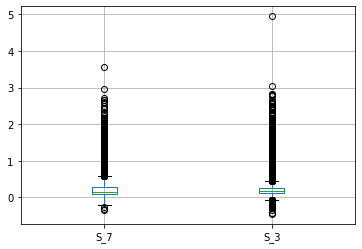

In [17]:
filtered = s_index[['S_7', 'S_3']]

filtered.boxplot()

In [18]:
filtered.isna().sum()

subresult = filtered[(filtered['S_7'].isna()) & (filtered['S_3'].isna())]

subresult

,S_7,S_3
3,NaN,NaN
7,NaN,NaN
12,NaN,NaN
18,NaN,NaN
22,NaN,NaN
...,...,...
276541,NaN,NaN
276546,NaN,NaN
276548,NaN,NaN
276558,NaN,NaN


Revisamos si es posible eliminar registros con muchas variables nulas, de los cuales no podemos extraer la informacion necesaria para el analisis

In [19]:
s_index.isna().sum(axis=1).sort_values()

0         0
150921    0
150922    0
150923    0
150924    0
         ..
53522     7
182623    7
102127    7
117420    7
135214    7
Length: 276572, dtype: int64

Al ser solo 7 columnas como maximo, de 190, no podemos eliminar registros por este metodo